In [2]:
import pickle

import torch
from scripts import model_setup
import pathlib
from torchvision.datasets import ImageFolder
from torch import nn
from torchvision.transforms import v2
from scripts import utilities

In [6]:
MODEL_FOLDER = pathlib.Path('./saved_models/ViT-B-16-pretrained')

In [9]:
vit_model_pretrained = model_setup.ViT_B_16(name='ViT_model_pretrained')

### Re-creating the same conditions of the feature extractor we trained on our dataset

In [11]:
vit_model_pretrained.pre_trained_model.heads = nn.Linear(
    in_features=768,
    out_features=5,
    bias=True
)

vit_model_pretrained.pre_trained_model.heads

Linear(in_features=768, out_features=5, bias=True)

In [12]:
HISTORY = 'HISTORY_ViT_model_pretrained_LR0.009_BS32_Classes5.pkl'
MODEL_CHECKPOINT = 'model_checkpoint_epoch_20.pt'

with open(MODEL_FOLDER / HISTORY, 'rb') as f:
    history_dict = pickle.load(f)

vit_model_pretrained.import_history(history_dict=history_dict)

with open(MODEL_FOLDER / MODEL_CHECKPOINT, 'rb') as f:
    checkpoint = torch.load(f)

vit_model_pretrained.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
TEST_SET_FOLDER = pathlib.Path('./Datasets/test')
PRETRAIN_RESIZE = (256, 256)

pretrain_transforms = nn.Sequential(
    v2.ToImage(),
    v2.Resize(PRETRAIN_RESIZE),
    v2.CenterCrop(size=224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
)

final_test_dataset = ImageFolder(TEST_SET_FOLDER, transform=pretrain_transforms)

In [16]:
final_test_dataset

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: Datasets/test
    StandardTransform
Transform: Sequential(
             (0): ToImage()
             (1): Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
             (2): CenterCrop(size=(224, 224))
             (3): ToDtype(scale=True)
             (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

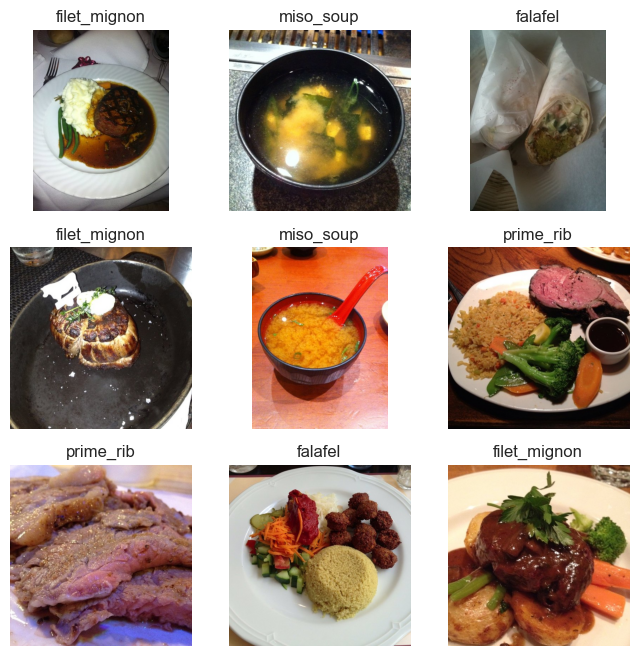

In [17]:
utilities.plot_samples(
    path=TEST_SET_FOLDER,
    classes_names=final_test_dataset.classes,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.3760507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8081232..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


NameError: name 'plt' is not defined

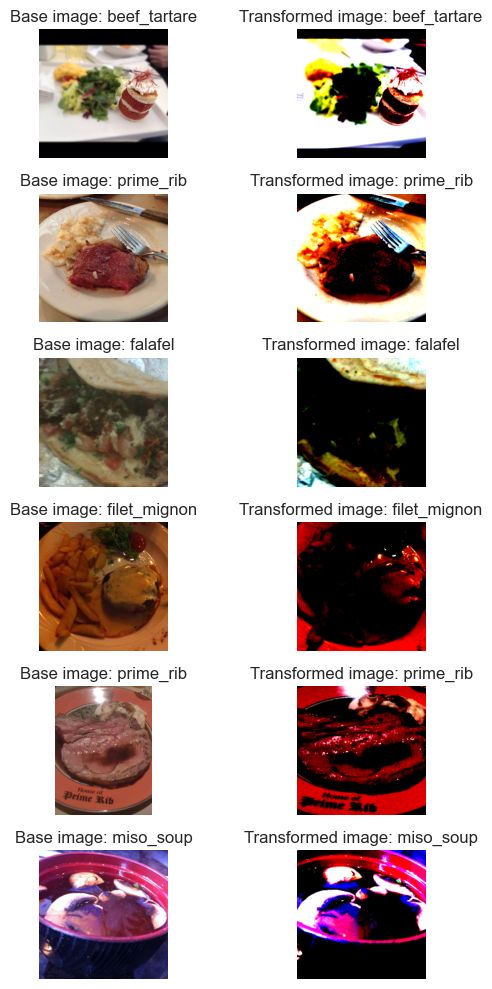

In [18]:
utilities.plot_samples_transformed(
    path=TEST_SET_FOLDER,
    classes_names=final_test_dataset.classes,
    transform=pretrain_transforms
)
plt.axis('off')

In [19]:
final_test_dataset.class_to_idx

{'beef_tartare': 0,
 'falafel': 1,
 'filet_mignon': 2,
 'miso_soup': 3,
 'prime_rib': 4}

In [20]:
from torch.utils.data import DataLoader
final_test_dataloader = DataLoader(
    dataset=final_test_dataset,
    batch_size=32,
)

In [21]:
device = 'mps' if torch.mps.is_available() else 'cpu'
vit_model_pretrained.to(device=device)
loss_list = []
acc_list = []
for X_batch, y_batch in final_test_dataloader:
    loss_batch, acc_batch = vit_model_pretrained.eval_step(
        batch_test_X=X_batch,
        batch_test_y=y_batch,
        loss_foo=nn.CrossEntropyLoss(),
        device=device,
    )
    loss_list.append(loss_batch)
    acc_list.append(acc_batch)


In [22]:
from numpy import mean
mean_loss = mean(loss_list)
mean_acc = mean(acc_list)

print(f'Mean loss: {mean_loss:.3f} | Mean acc: {mean_acc:.3%}')

Mean loss: 0.287 | Mean acc: 90.723%


In [23]:
def predict(X_batch, model, device):
    pred_list = []
    vit_model_pretrained.eval()
    with torch.no_grad():
        for X_batch, y_batch in final_test_dataloader:
            X_batch = X_batch.to(device)
            pred = vit_model_pretrained(X_batch)
            pred_list.append(pred)
    return torch.vstack(pred_list)

logits = predict(X_batch, vit_model_pretrained, device)
pred_proba = torch.softmax(logits, dim=1)
prediction = torch.argmax(pred_proba, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2739873].


Text(0.5, 1.0, 'Original label: 1 | Predicted label: 1')

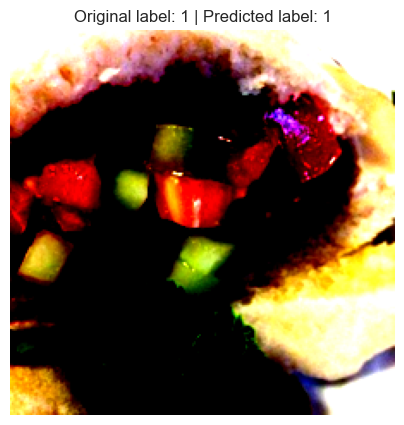

In [24]:
from random import randint
import matplotlib.pyplot as plt
random_pic = randint(0, len(final_test_dataset))
plt.figure(figsize=(5, 5))
plt.imshow(final_test_dataset[random_pic][0].permute(1, 2, 0))
plt.axis('off')
plt.title(f"Original label: {final_test_dataset[random_pic][1]} | Predicted label: {prediction[random_pic]}")


In [25]:
final_test_dataset.class_to_idx

{'beef_tartare': 0,
 'falafel': 1,
 'filet_mignon': 2,
 'miso_soup': 3,
 'prime_rib': 4}

In [26]:
targets = torch.Tensor(final_test_dataset.targets)

Text(0.5, 1.0, 'Confusion Matrix')

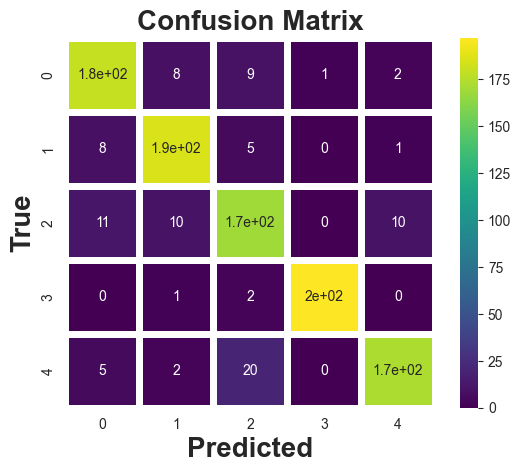

In [27]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(
    confusion_matrix(targets, prediction.to('cpu')),
    square=True,
    cmap='viridis',
    annot=True,
    linewidths=5,
    linecolor='white',
)
plt.xlabel('Predicted', fontsize=20, fontweight='bold')
plt.ylabel('True', fontsize=20, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')